In [1]:
##Imports
%matplotlib inline
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json

In [2]:
## This is to get the connection to the nba endpoints correctly (hot fix to work until they push changes)
headers = {
    'Host': 'stats.nba.com',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:61.0) Gecko/20100101 Firefox/61.0',
    'Accept': 'application/json, text/plain, */*',
    'Accept-Language': 'en-US,en;q=0.5',
    'Referer': 'https://stats.nba.com/',
    'Accept-Encoding': 'gzip, deflate, br',
    'Connection': 'keep-alive',
}

In [3]:
## This is function to draw nba_court
from matplotlib.patches import Circle, Rectangle, Arc

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [4]:
from nba_api.stats.static import teams
nba_teams = teams.get_teams()
# Select the dictionary for the Heat, which contains their team ID
heat = [team for team in nba_teams if team['abbreviation'] == 'MIA'][0]
heat_id = heat['id']
print(heat_id)

1610612748


In [5]:
from nba_api.stats.endpoints import leaguegamefinder
#Query for games where the Heat were playing
gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=heat_id, headers=headers)
# The first DataFrame of those returned is what we want.
heat_games = gamefinder.get_data_frames()[0]
heat_games.head()
heat_gameids = heat_games['GAME_ID'].values

In [6]:
from nba_api.stats.endpoints import boxscoreadvancedv2

bs = boxscoreadvancedv2.BoxScoreAdvancedV2(game_id='0021900126', headers=headers).get_json()
boxscore = json.loads(bs)
TEAM = 1
PLAYER = 0
player_stats = boxscore["resultSets"][PLAYER]["rowSet"]
stat_headers = boxscore["resultSets"][PLAYER]["headers"]
team_stats = boxscore["resultSets"][TEAM]["rowSet"]
teamStat_header = boxscore["resultSets"][TEAM]["headers"]

In [7]:
## Build the team name to team_id map
list_teams = ['ATL', 'BOS', 'CLE', 'NOP', 'CHI', 'DAL', 'DEN', 'GSW', 'HOU', 'LAC', 'LAL'
        , 'MIA', 'MIL', 'MIN', 'BKN', 'NYK', 'ORL', 'IND', 'PHI', 'PHX', 'POR', 'SAC'
        , 'SAS', 'OKC', 'TOR', 'UTA', 'MEM', 'WAS', 'DET', 'CHA']
i = 0
team_to_id = {}
for t in list_teams:
    team_to_id.update({t: nba_teams[i]['id']})
    i += 1
print(team_to_id)

{'ATL': 1610612737, 'BOS': 1610612738, 'CLE': 1610612739, 'NOP': 1610612740, 'CHI': 1610612741, 'DAL': 1610612742, 'DEN': 1610612743, 'GSW': 1610612744, 'HOU': 1610612745, 'LAC': 1610612746, 'LAL': 1610612747, 'MIA': 1610612748, 'MIL': 1610612749, 'MIN': 1610612750, 'BKN': 1610612751, 'NYK': 1610612752, 'ORL': 1610612753, 'IND': 1610612754, 'PHI': 1610612755, 'PHX': 1610612756, 'POR': 1610612757, 'SAC': 1610612758, 'SAS': 1610612759, 'OKC': 1610612760, 'TOR': 1610612761, 'UTA': 1610612762, 'MEM': 1610612763, 'WAS': 1610612764, 'DET': 1610612765, 'CHA': 1610612766}


In [8]:
# Franchise leaders
from nba_api.stats.endpoints import franchiseleaders
fl = franchiseleaders.FranchiseLeaders(team_id=team_to_id["MIA"], headers=headers)
leaders = fl.get_data_frames()[0]
leaders.head()

,TEAM_ID,PTS,PTS_PERSON_ID,PTS_PLAYER,AST,AST_PERSON_ID,AST_PLAYER,REB,REB_PERSON_ID,REB_PLAYER,BLK,BLK_PERSON_ID,BLK_PLAYER,STL,STL_PERSON_ID,STL_PLAYER
0,1610612748,21556,2548,Dwyane Wade,5310,2548,Dwyane Wade,5741,2617,Udonis Haslem,1625,297,Alonzo Mourning,1492,2548,Dwyane Wade


In [9]:
from nba_api.stats.endpoints import shotchartdetail
## This is for Dwyane Wade
sc = shotchartdetail.ShotChartDetail(team_id=team_to_id['MIA'], player_id=2548, headers=headers)
shotchart_player = sc.get_data_frames()[0]
shotchart_player.head()

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0020300001,16,2548,Dwyane Wade,1610612748,Miami Heat,1,10,6,...,Left Side(L),8-16 ft.,8,-84,-21,1,1,20031028,PHI,MIA
1,Shot Chart Detail,0020300001,18,2548,Dwyane Wade,1610612748,Miami Heat,1,9,21,...,Center(C),Less Than 8 ft.,3,-38,8,1,1,20031028,PHI,MIA
2,Shot Chart Detail,0020300001,54,2548,Dwyane Wade,1610612748,Miami Heat,1,4,58,...,Left Side(L),8-16 ft.,8,-77,35,1,1,20031028,PHI,MIA
3,Shot Chart Detail,0020300001,66,2548,Dwyane Wade,1610612748,Miami Heat,1,4,2,...,Center(C),Less Than 8 ft.,0,0,0,1,1,20031028,PHI,MIA
4,Shot Chart Detail,0020300001,228,2548,Dwyane Wade,1610612748,Miami Heat,2,0,41,...,Center(C),Less Than 8 ft.,0,0,0,1,1,20031028,PHI,MIA


/home/vishnu/.local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.5,1.2,'Dwyane Wade FGA Career')

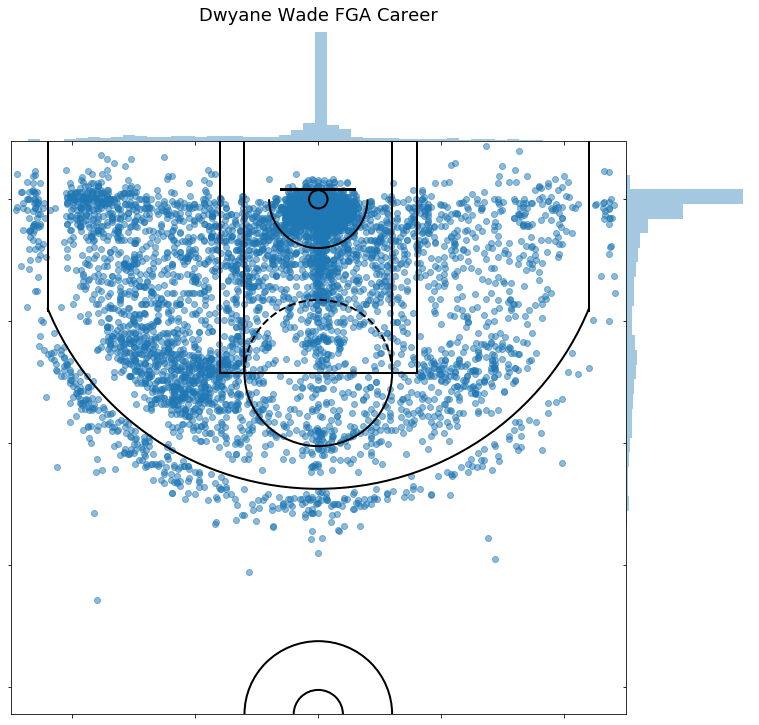

In [10]:
joint_shot_chart = sns.jointplot(shotchart_player.LOC_X, shotchart_player.LOC_Y, stat_func=None,
                                 kind='scatter', space=0, alpha=0.5)
joint_shot_chart.fig.set_size_inches(12,11)
# A joint plot has 3 Axes, the first one called ax_joint
# is the one we want to draw our court onto and adjust some other settings
ax = joint_shot_chart.ax_joint
draw_court(ax)
# Adjust the axis limits and orientation of the plot in order
# to plot half court, with the hoop by the top of the plot
ax.set_xlim(-250,250)
ax.set_ylim(422.5, -47.5)
# Get rid of axis labels and tick marks
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(labelbottom='off', labelleft='off')
# Add a title
ax.set_title('Dwyane Wade FGA Career',
             y=1.2, fontsize=18)

In [29]:
from nba_api.stats.endpoints import playergamelog
## Lebron James
pgl = playergamelog.PlayerGameLog(player_id=2544, headers=headers)
gamelog = pgl.get_data_frames()[0]
gamelog.head()
attributes = list(gamelog.columns.values)

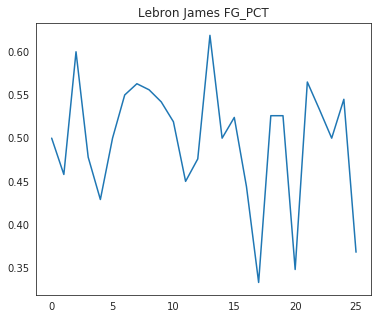

In [27]:
sns.set_style("white")
sns.set_color_codes()
plt.figure(figsize=(6,5))
plt.title('Lebron James FG_PCT')
plt.plot(range(gamelog.shape[0]), gamelog.FG_PCT)
plt.show()

In [13]:
### This is IDEA #2
### TODO: Experiment with different methods to get metrics 

def determine_stats_to_winning(player_game_data, player_name):  
    FG_PCT_THRESHOLD = 0.5
    
    stats_win_index = player_game_data.PTS + (2 * player_game_data.AST) 
    + (1.5 * player_game_data.REB) - 2 * (player_game_data.TOV + player_game_data.PF)
    + 2 * (player_game_data.STL + player_game_data.BLK)

    plt.scatter(stats_win_index, player_game_data.PLUS_MINUS, s=300, c=player_game_data.FG_PCT)
    plt.title(player_name)
    plt.show()

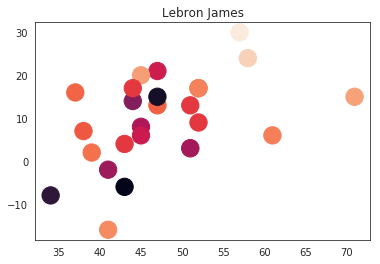

In [14]:
determine_stats_to_winning(gamelog, 'Lebron James')

In [15]:
# Make API Call for players across all seasons for a particular franchise
from nba_api.stats.endpoints import franchiseplayers
fp = franchiseplayers.FranchisePlayers(team_id=team_to_id["DAL"], headers=headers)
players = fp.get_data_frames()[0]
players.head()

,LEAGUE_ID,TEAM_ID,TEAM,PERSON_ID,PLAYER,SEASON_TYPE,ACTIVE_WITH_TEAM,GP,FGM,FGA,...,FT_PCT,OREB,DREB,REB,AST,PF,STL,TOV,BLK,PTS
0,00,1610612742,Dallas Mavericks,23,Dennis Rodman,Regular Season,0,12,12,31,...,0.714,48,123,171,14,41,2,19,1,34
1,00,1610612742,Dallas Mavericks,31,Lorenzo Williams,Regular Season,0,181,280,621,...,0.372,617,803,1420,232,619,115,204,311,634
2,00,1610612742,Dallas Mavericks,35,Eric Riley,Regular Season,0,39,56,135,...,0.750,43,90,133,22,80,15,37,46,139
3,00,1610612742,Dallas Mavericks,45,George McCloud,Regular Season,0,162,878,2091,...,0.818,227,442,669,357,389,188,258,55,2462
4,00,1610612742,Dallas Mavericks,57,Doug Christie,Regular Season,0,7,9,26,...,0.667,2,11,13,14,10,9,6,1,26


In [16]:
# Build the list of players in the 2019-2020 season
active_players = players.loc[players['ACTIVE_WITH_TEAM'] == 1]
ids_per_team = active_players['PERSON_ID'].values
player_names = active_players['PLAYER'].values
players_per_team = dict(zip(ids_per_team, player_names))
print(players_per_team)

{200826: 'J.J. Barea', 201584: 'Courtney Lee', 203501: 'Tim Hardaway Jr.', 203552: 'Seth Curry', 203939: 'Dwight Powell', 204001: 'Kristaps Porzingis', 1626153: 'Delon Wright', 1626246: 'Boban Marjanovic', 1627827: 'Dorian Finney-Smith', 1628382: 'Justin Jackson', 1628467: 'Maxi Kleber', 1628499: 'Antonius Cleveland', 1628973: 'Jalen Brunson', 1629029: 'Luka Doncic', 1629151: 'Ryan Broekhoff'}


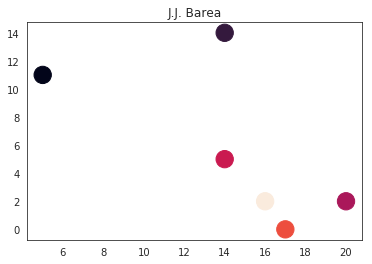

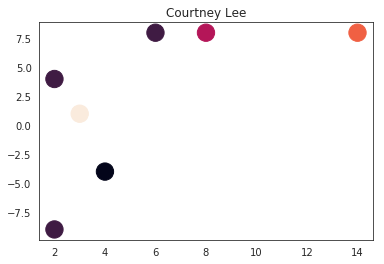

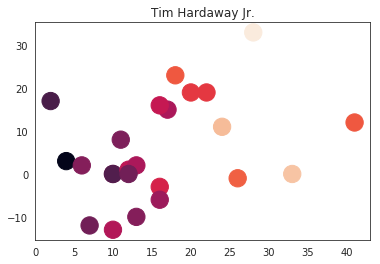

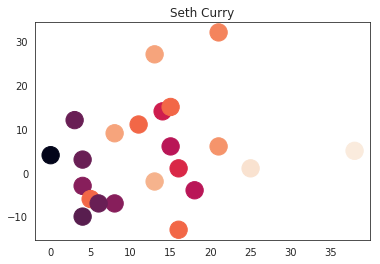

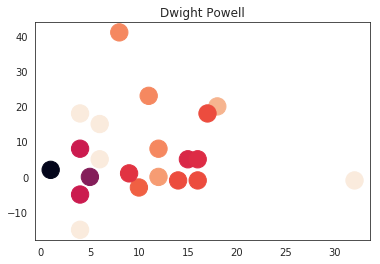

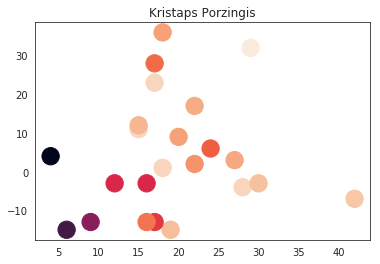

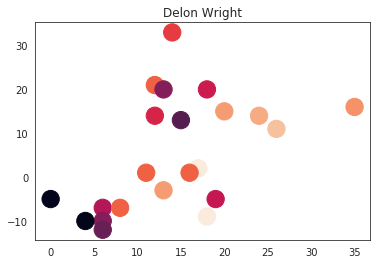

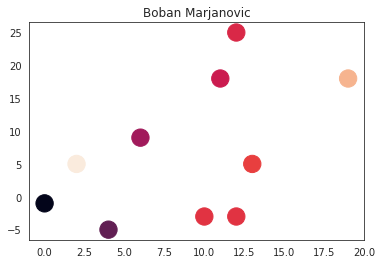

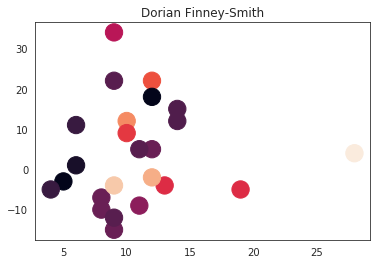

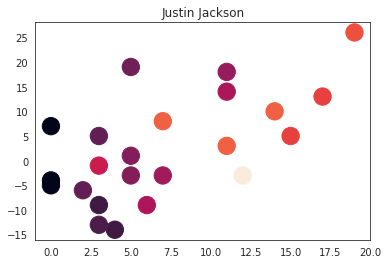

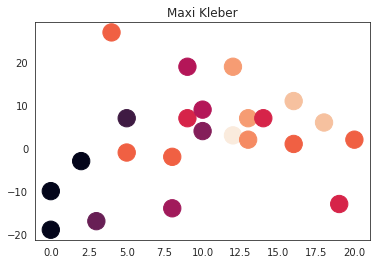

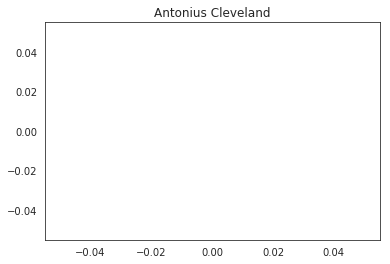

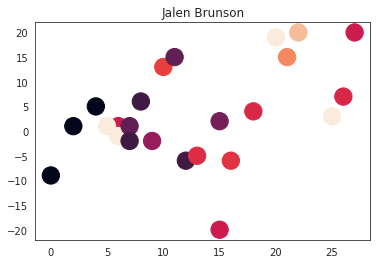

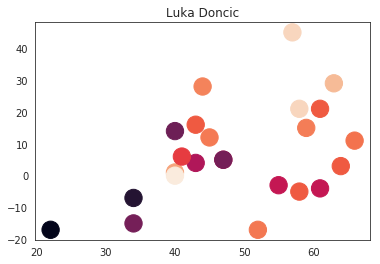

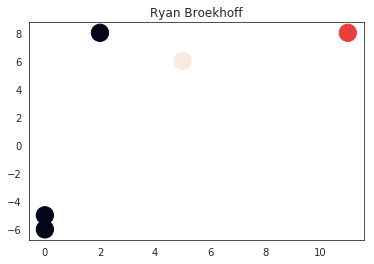

In [17]:
## Get the relationship for every player
for player in players_per_team:
    pgl = playergamelog.PlayerGameLog(player_id=player, headers=headers)
    player_game_data = pgl.get_data_frames()[0]
    determine_stats_to_winning(player_game_data, players_per_team[player])

The next section is to be able to get clustering of types of players, hierarchical and interconnected. This is something you can put in DDB and have a queue select players at random to display or something of the sort :)

In [51]:
nba2019_2020players = {}
for team in list_teams:
    fp = franchiseplayers.FranchisePlayers(team_id=team_to_id[team], headers=headers)
    players = fp.get_data_frames()[0]
    active_players = players.loc[players['ACTIVE_WITH_TEAM'] == 1]
    ids_per_team = active_players['PERSON_ID'].values
    player_names = active_players['PLAYER'].values
    players_per_team = dict(zip(ids_per_team, player_names))
    nba2019_2020players.update(players_per_team)

In [30]:
print(attributes)

['SEASON_ID', 'Player_ID', 'Game_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE']


In [36]:
print(sum(gamelog.FG3_PCT.values)/len(gamelog.FG3_PCT.values))
print(np.mean(gamelog.FG3_PCT.values) > 0.3)

0.4293809523809524
True


In [52]:
## Determine_condition or ret true if you cant
def dc(values, sign, threshold): 
    if len(values) > 0:
        if sign == 'l':
            return np.mean(values) < threshold
        elif sign == "g":
            return np.mean(values) > threshold
    else:
        return True

def classify_players(players):
    three_and_d_players = []
    facilitators = []
    spot_up_shooters = []
    defenders = []
    athletic = []
    elite_two_way = []
    iso = []
    other = []
    for player in players:
        pgl = playergamelog.PlayerGameLog(player_id=player, headers=headers)
        gamelog = pgl.get_data_frames()[0]
        if dc(gamelog.FG3_PCT.values, 'g', 0.38) and dc(gamelog.STL.values, 'g', 1.5) and dc(gamelog.BLK.values, 'g', 0.5):
            three_and_d_players.append((player, players[player]))
        elif dc(gamelog.AST.values, 'g', 7.0) and dc(gamelog.PTS.values, 'l', 18) and dc(gamelog.FG_PCT.values, 'g', 0.45):
            facilitators.append((player, players[player]))
        elif dc(gamelog.FG_PCT.values, 'g', 0.5) and dc(gamelog.FG3_PCT.values, 'g', 0.4) and dc(gamelog.FG3A.values, 'g', 7):
            spot_up_shooters.append((player, players[player]))
        elif dc(gamelog.REB.values, 'g', 5) and dc(gamelog.STL.values, 'g', 1.5) and dc(gamelog.BLK.values, 'g', 0.7):
            defenders.append((player, players[player]))
        elif dc(gamelog.REB.values, 'g', 7) and dc(gamelog.PTS.values, 'g', 20) and dc(gamelog.STL.values, 'g', 1) and dc(gamelog.BLK.values, 'g', 1):
            athletic.append((player, players[player]))
        elif dc(gamelog.PTS.values, 'g', 25) and dc(gamelog.REB.values, 'g', 6) and dc(gamelog.FG_PCT.values, 'g', 0.52) and dc(gamelog.AST.values, 'g', 5) and dc(gamelog.STL.values, 'g', 1) and dc(gamelog.BLK.values, 'g', 0.8):
            elite_two_way.append((player, players[player]))
        elif dc(gamelog.PTS.values, 'g', 20) and dc(gamelog.AST.values, 'l', 5) and dc(gamelog.FG_PCT.values, 'g', 0.4):
            iso.append((player, players[player]))
        else:
            other.append((player, players[player]))

    print("3-D players are: ")
    print(three_and_d_players)
    print("Facilitators are: ")
    print(facilitators)
    print("Spot up shooters are: ")
    print(spot_up_shooters)
    print("Defenders are: ")
    print(defenders)
    print("Athletic players are: ")
    print(athletic)
    print("elite 2 way players are: ")
    print(elite_two_way)
    print("iso players are: ")
    print(iso)
    #print("other 'role' players are: ")
    #print(other)
    return (three_and_d_players, facilitators, spot_up_shooters, defenders, athletic, elite_two_way, iso, other)

In [53]:
d3, fac, spot, defenders, athletic, e2way, iso, role = classify_players(nba2019_2020players)

3-D players are: 
[(203121, 'Darius Miller'), (1626245, 'Cristiano Felicio'), (1628499, 'Antonius Cleveland'), (202691, 'Klay Thompson'), (2403, 'Nene'), (101123, 'Gerald Green'), (203079, 'Dion Waiters'), (203506, 'Victor Oladipo'), (1629015, 'Zhaire Smith'), (203994, 'Jusuf Nurkic'), (203460, 'Andre Roberson'), (202322, 'John Wall')]
Facilitators are: 
[(1627732, 'Ben Simmons')]
Spot up shooters are: 
[(1626157, 'Karl-Anthony Towns')]
Defenders are: 
[(201950, 'Jrue Holiday'), (203083, 'Andre Drummond')]
Athletic players are: 
[(203076, 'Anthony Davis'), (203507, 'Giannis Antetokounmpo')]
elite 2 way players are: 
[]
iso players are: 
[(1628369, 'Jayson Tatum'), (1627742, 'Brandon Ingram'), (203897, 'Zach LaVine'), (202331, 'Paul George'), (203952, 'Andrew Wiggins'), (203095, 'Evan Fournier'), (203954, 'Joel Embiid'), (203468, 'CJ McCollum'), (1627741, 'Buddy Hield'), (201942, 'DeMar DeRozan'), (1627783, 'Pascal Siakam'), (202711, 'Bojan Bogdanovic'), (1628378, 'Donovan Mitchell')]


In [99]:
def build_player_counting_stats(players):
    total_stats = []
    for player in players:
        pgl = playergamelog.PlayerGameLog(player_id=player[0], headers=headers)
        gamelog = pgl.get_data_frames()[0]
        if len(gamelog.PTS.values) > 0 and len(gamelog.AST.values) > 0 and len(gamelog.REB.values) > 0 and len(gamelog.STL.values) > 0 and len(gamelog.BLK.values) > 0 and len(gamelog.FG_PCT.values) > 0 and len(gamelog.FG3_PCT.values) > 0 and len(gamelog.FT_PCT.values) > 0:
            total_stats.append([np.round(np.mean(gamelog.PTS.values),2), np.round(np.mean(gamelog.AST.values),2),
                                np.round(np.mean(gamelog.REB.values),2), np.round(np.mean(gamelog.FG_PCT.values),2),
                                np.round(np.mean(gamelog.STL.values),2), np.round(np.mean(gamelog.FG3_PCT.values),2),
                                np.round(np.mean(gamelog.BLK.values),2), np.round(np.mean(gamelog.FT_PCT.values),2)])
        else:
            total_stats.append([0,0,0,0,0,0,0,0])
    return total_stats

In [100]:
def build_table_for_clusters(players, labels):
    data = []
    for i in range(len(players)):
        data.append([players[i][1], labels[i]])
    return pd.DataFrame(data, columns=['Player Name', 'Label'])

In [101]:
from sklearn.cluster import KMeans
import numpy as np
X = build_player_counting_stats(role)
kmeans = KMeans(n_clusters=7, random_state=0).fit(X)

In [102]:
table = build_table_for_clusters(role, kmeans.labels_)
print(table.shape)
## Also print out the clusters that are smallest in size.
## TODO: do the cluster analysis, and use all the counting stats! 

(438, 2)


In [103]:
print(table.loc[table['Label'] == 0].shape)

(104, 2)


In [104]:
print(table.loc[table['Label'] == 1].shape)
print(table.loc[table['Label'] == 1])

(19, 2)
            Player Name  Label
8          John Collins      1
30           Kevin Love      1
31     Tristan Thompson      1
67   Wendell Carter Jr.      1
77   Kristaps Porzingis      1
91         Nikola Jokic      1
122        Clint Capela      1
164         Bam Adebayo      1
211       Jarrett Allen      1
220       Julius Randle      1
233      Nikola Vucevic      1
253    Domantas Sabonis      1
285       Deandre Ayton      1
292    Hassan Whiteside      1
310      Richaun Holmes      1
338        Steven Adams      1
366         Rudy Gobert      1
377   Jonas Valanciunas      1
399       Thomas Bryant      1


In [105]:
print(table.loc[table['Label'] == 2].shape)

(83, 2)


In [106]:
print(table.loc[table['Label'] == 3].shape)

(59, 2)


In [110]:
print(table.loc[table['Label'] == 4].shape)

(117, 2)


In [111]:
print(table.loc[table['Label'] == 5].shape)
print(table.loc[table['Label'] == 5])

(12, 2)
           Player Name  Label
11          Trae Young      5
17        Kemba Walker      5
84         Luka Doncic      5
104   D'Angelo Russell      5
117  Russell Westbrook      5
119       James Harden      5
130      Kawhi Leonard      5
142       LeBron James      5
203       Kyrie Irving      5
281       Devin Booker      5
293     Damian Lillard      5
397       Bradley Beal      5


In [109]:
print(table.loc[table['Label'] == 6].shape)

(44, 2)
